# Agenda for Today's Demo

### 1. **Batch Model Training**

### 2. **Batch Scoring**

### 3. **Real-time Scoring**

# call the libraries

In [1]:
from pyspark.sql import SparkSession
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import io
import numpy as np
import scipy.stats as stats
import pylab as pl
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
import numpy as np
from pyspark.ml.feature import MinMaxScaler
%matplotlib inline



# initialize spark and spark context

In [2]:
spark = SparkSession.builder.appName('demo-anomaly-profile-dome9-ip-pyspark-kmeans-batch-train').getOrCreate()
sc = spark.sparkContext
sc.version

'2.1.1'

In [3]:
data_source = "dome9"
tenant_name = "demo"
time_window="day"
entity_type="ip"
anomaly_type="profile"
model_type="pyspark"
model_name="kmeans"

BASE_PATH = "/Users/tuhinsharma/Documents/sstech/"+tenant_name
ANOMALY_DATA_REPOSITORY = BASE_PATH + "/models_data/data"

USER_PROFILE_DATA_PATH = ANOMALY_DATA_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}.json"
data_path = USER_PROFILE_DATA_PATH.format\
                                           (data_source=data_source,\
                                            entity_type=entity_type,anomaly_type="profile",time_window=time_window)
    
ANOMALY_MODEL_REPOSITORY = BASE_PATH + "/models_data/model"
PROFILE_ANOMALY_MODEL_PATH = ANOMALY_MODEL_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}/{model_type}/{model_name}"


# Lets load the Profile data for DOME9 with 3 attributes

In [4]:
ip_profile_sdf = spark.read.json(data_path).persist()
ip_profile_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
|              1446|            False|           False|        655|               1115|  54.85.1.3|
|              1421|            False|           False|        635|               1115| 54.85.5.15|
|              1392|             True|           False|        629|               1090|54.85.10.16|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
only showing top 3 rows



# Convert to Pandas dataframe

In [5]:
ip_profile_df = ip_profile_sdf.toPandas()

# Visualize and Understand trend

In [6]:
logon_count = ip_profile_df["logon_count"]
inbound_conn_count = ip_profile_df["inbound_conn_count"]
outbound_conn_count = ip_profile_df["outbound_conn_count"]



### Boxplot for logon_count and inbound_conn_count and outbound_conn_count


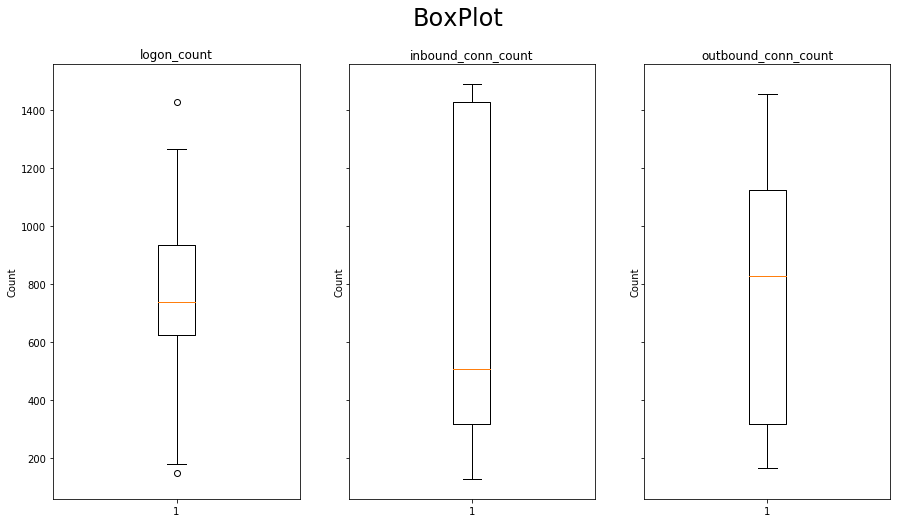

In [7]:
plt.close()

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))
axs[0].boxplot(logon_count)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('Count')


axs[1].boxplot(inbound_conn_count)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('Count')


axs[2].boxplot(outbound_conn_count)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('Count')


fig.suptitle("BoxPlot", fontsize=24,)

plt.show()
plt.close()



### Density plot for logon_count and inbound_conn_count and outbound_conn_count

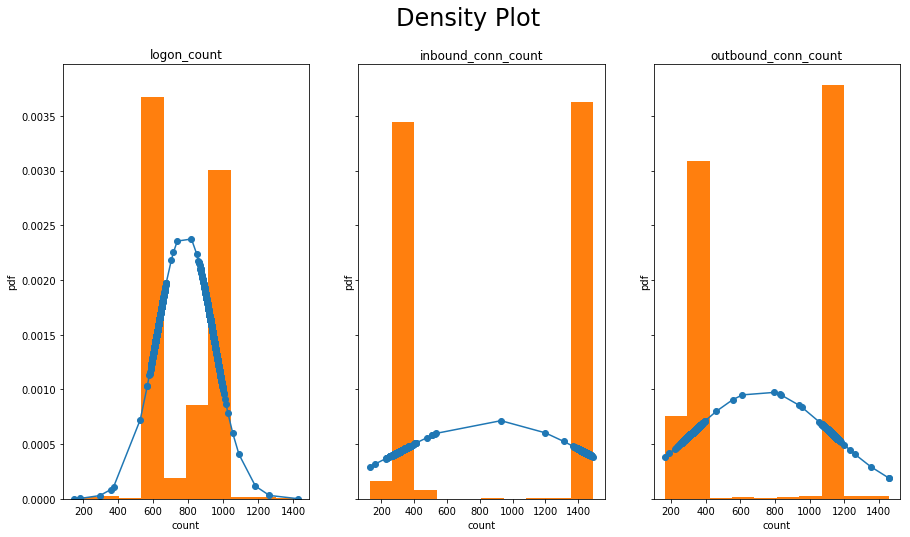

In [8]:
plt.close()

h1 = sorted(logon_count)
h2 = sorted(inbound_conn_count)
h3 = sorted(outbound_conn_count)

fit1 = stats.norm.pdf(h1, np.mean(h1), np.std(h1))
fit2 = stats.norm.pdf(h2, np.mean(h2), np.std(h2))
fit3 = stats.norm.pdf(h3, np.mean(h3), np.std(h3))


fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))

axs[0].plot(h1,fit1,'-o')
axs[0].hist(h1,density=True)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('pdf')
axs[0].set_xlabel('count')


axs[1].plot(h2,fit2,'-o')
axs[1].hist(h2,density=True)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('pdf')
axs[1].set_xlabel('count')


axs[2].plot(h3,fit3,'-o')
axs[2].hist(h3,density=True)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('pdf')
axs[2].set_xlabel('count')

fig.suptitle("Density Plot", fontsize=24)



plt.show()
plt.close()




### Histogram plot for logon_count and inbound_conn_count and outbound_conn_count

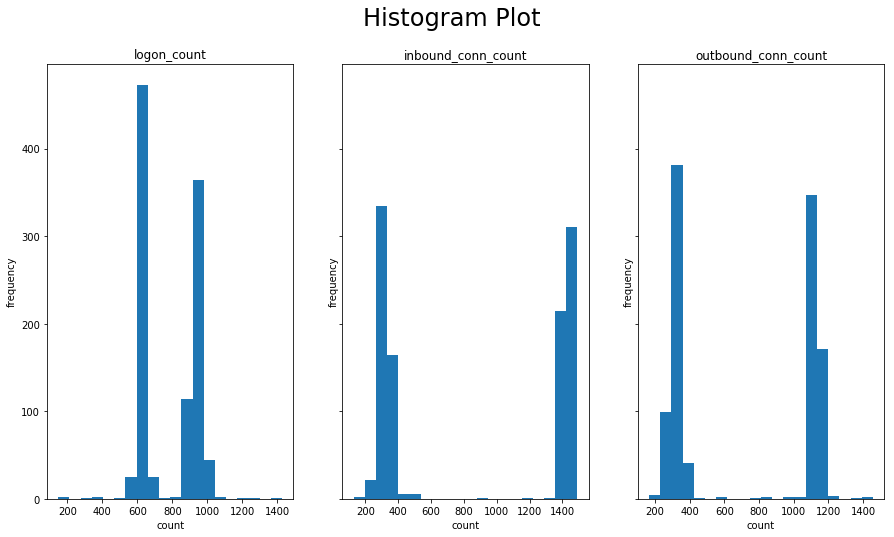

In [9]:
plt.close()
n_bins = 20

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False,figsize=(15,8))

axs[0].hist(logon_count, bins=n_bins)
axs[0].title.set_text('logon_count')
axs[0].set_ylabel('frequency')
axs[0].set_xlabel('count')


axs[1].hist(inbound_conn_count, bins=n_bins)
axs[1].title.set_text('inbound_conn_count')
axs[1].set_ylabel('frequency')
axs[1].set_xlabel('count')


axs[2].hist(outbound_conn_count, bins=n_bins)
axs[2].title.set_text('outbound_conn_count')
axs[2].set_ylabel('frequency')
axs[2].set_xlabel('count')

fig.suptitle("Histogram Plot", fontsize=24)

plt.show()
plt.close()

## Define the columns on which Model shall be trained

In [10]:
cat_colnames = ["increase_activity","lateral_movement"]
num_colnames = ["logon_count","inbound_conn_count","outbound_conn_count"]

# Batch Training

### Clustering Pipelinemodel

In [11]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
string_indexer_list = list()
one_hot_encoder_list = list()
for cat_colname in cat_colnames:
    string_indexer = StringIndexer(inputCol=cat_colname, outputCol=cat_colname+"_index")
    string_indexer_list.append(string_indexer)
    one_hot_encoder = OneHotEncoder(inputCol=cat_colname+"_index", outputCol=cat_colname+"_vec")
    one_hot_encoder_list.append(one_hot_encoder)

In [12]:
out = []
pipe = []
if len(num_colnames)>0:
    assembler = VectorAssembler(inputCols=num_colnames,outputCol="features_vec")
    standard_scaler = StandardScaler(inputCol="features_vec", outputCol="features_zs",withMean=True,withStd=True)
    out = [standard_scaler.getOutputCol()]
    pipe = [assembler,standard_scaler]
assembler_2 = VectorAssembler(inputCols=[x.getOutputCol() for x in one_hot_encoder_list]+out,outputCol="features")
estimator = KMeans(featuresCol="features",predictionCol="cluster_id",k=4)

clustering_pipeline = Pipeline(stages=string_indexer_list+one_hot_encoder_list+pipe+[assembler_2]+[estimator])
clustering_pipeline_model = clustering_pipeline.fit(ip_profile_sdf)



In [13]:
result_cluster_sdf = clustering_pipeline_model.transform(ip_profile_sdf).persist()
result_cluster_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              1446|            False|           False|        655|               1115|  54.85.1.3|                    1.0|                   1.0|            (1,[],[])|           (1,[],[])|[655.0,1446.0,111..

### For each data points calculate sum of euclidean distance (SED) for all the cluster centroids

In [14]:
def calculate_SED_from_all_centroids(value,centroids):
    single_point = value
    points = centroids

    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    dist = np.sum(dist)
    return float(dist)

def udf_calculate_SED(centroid_list):
    return udf(lambda l: calculate_SED_from_all_centroids(l, centroid_list),FloatType())

centroids = np.array(clustering_pipeline_model.stages[-1].clusterCenters())
print("number of centroids : ",centroids.shape[0])
print(centroids)

result_score_sdf = result_cluster_sdf.withColumn("sed", udf_calculate_SED(centroids)(col("features")))
result_score_sdf.show(3)

number of centroids :  4
[[ 0.66831683  0.36138614 -0.94998226  0.98998584  0.99410979]
 [ 0.          1.         -0.98850857  0.94929888  0.95640871]
 [ 0.50775194  0.          0.97055968 -0.98689457 -0.98747742]
 [ 0.5202952   1.          0.95181002 -0.97766472 -0.98656339]]
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+--------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|     sed|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------

### Calculate Anomaly Score based on the sed

In [15]:
assembler = VectorAssembler(inputCols=["sed"],outputCol="sed_vec")
scaler = MinMaxScaler(inputCol="sed_vec", outputCol="scaled_sed")

scoring_pipeline = Pipeline(stages=[assembler,scaler])
scoring_pipeline_model = scoring_pipeline.fit(result_score_sdf)

result_scaler_sdf = scoring_pipeline_model.transform(result_score_sdf)
result_scaler_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+--------+-------------------+--------------------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|     sed|            sed_vec|          scaled_sed|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+--------+-------------------+--------------------+
|              1446|            False|           False|   

In [16]:
model_path = PROFILE_ANOMALY_MODEL_PATH.format(data_source=data_source,\
                                  entity_type=entity_type,anomaly_type=anomaly_type,time_window=time_window,\
                                 model_type=model_type,model_name=model_name)

### Save the Clustering Pipelinemodel

In [17]:

clustering_pipeline_model.write().overwrite().save(model_path+"/clustering_pipeline_model")


### Save the Scoring Pipelinemodel

In [18]:

scoring_pipeline_model.write().overwrite().save(model_path+"/scoring_pipeline_model")
